In [ ]:
!pip install -q visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 24.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
from keras.src.saving import load_model
from keras.src.layers import *
from keras.src.optimizers import AdamW
from keras.src.losses import *
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import backend as K
import random as rand
import matplotlib.image as mlt
import pandas as pd
from multiprocessing import Pool, cpu_count
from time import time
from keras.src.models import Model
from keras.src.callbacks import *
from keras.src.saving import register_keras_serializable
import visualkeras

In [ ]:
# Chọn thư mục hoạt động

%cd /content/drive/MyDrive/AI/DL/segmentation_task

/content/drive/MyDrive/AI/DL/segmentation_task


In [ ]:
# Tạo thư mục liên quan

!rm -rf models/chest_xray/
!rm -rf logs/chest_xray/
!rm -rf imgs/chest_xray/

!mkdir -p models/chest_xray/
!mkdir -p logs/chest_xray/
!mkdir -p datasets/chest_xray/
!mkdir -p imgs/chest_xray/


In [ ]:
# Nạp API key Kaggle

!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp -f ../../api_keys/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Thiết lập đường dẫn chung

ds_path = 'datasets/chest_xray/'
log_path = 'logs/chest_xray/'
model_path = 'models/chest_xray/'
img_path = 'imgs/chest_xray/'

# Tải dữ liệu

In [ ]:
import kaggle as kg

# kg.api.dataset_download_files(
#     'nikhilpandey360/chest-xray-masks-and-labels',
#     path=ds_path,
#     unzip=True,
#     quiet=False
# )

In [ ]:
# Khái quát cấu trúc

!ls {ds_path}

data  lung_segmentation


In [ ]:
# Đổi tên thư mục

if os.path.exists(os.path.join(ds_path, 'Lung Segmentation')):
  os.rename(os.path.join(ds_path, 'Lung Segmentation'), os.path.join(ds_path, 'lung_segmentation'))

In [ ]:
# Cập nhật đường dẫn dataset

ds_path = os.path.join(ds_path, 'lung_segmentation')

# Nạp dữ liệu

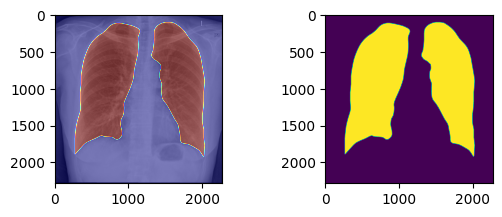

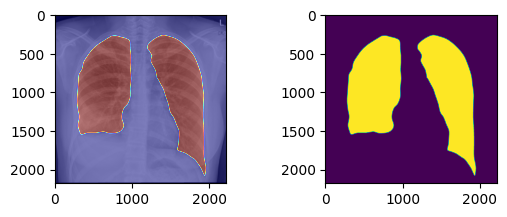

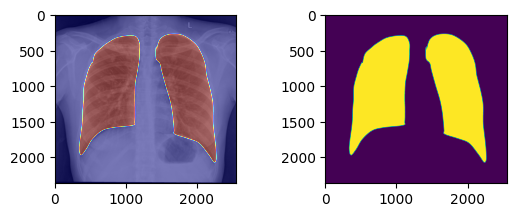

In [ ]:
# In thử vài điểm dữ liệu gồm ảnh & mask

def view_sample():
  img_sample_path = os.path.join(ds_path, 'CXR_png')
  mask_sample_path = os.path.join(ds_path, 'masks')
  sample_name = rand.sample(os.listdir(img_sample_path), 1)[0]
  sample_name = sample_name.split('.')[0]

  img = mlt.imread(os.path.join(img_sample_path, sample_name + '.png'))
  mask = mlt.imread(os.path.join(mask_sample_path, sample_name + '_mask.png'))

  plt.subplot(2, 2, 1)
  plt.imshow(img)
  plt.imshow(mask, cmap='jet', alpha=0.5)
  plt.subplot(2, 2, 2)
  plt.imshow(mask)
  plt.show()

for i in range(3):
  try:
    view_sample()
  except Exception as e:
    i-=1

In [ ]:
# Phân tách dữ liệu theo cặp ảnh & mask

img_path = os.path.join(ds_path, 'CXR_png')
mask_path = os.path.join(ds_path, 'masks')
data = {}

for img in os.listdir(img_path):
  for mask in os.listdir(mask_path):
    if img[:11] == mask[:11]:
      data[os.path.join(img_path, img)] = os.path.join(mask_path, mask)

data_df = pd.DataFrame(list(data.items()), columns=['img', 'mask'])
data_df.head(5)

,img,mask
0,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...
1,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...
2,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...
3,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...
4,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...


In [ ]:
# Phân tách theo nhãn bệnh lý

def label_splitted(img_path):
  label = img_path[-5:-4]
  return label

data_df['label'] = data_df['img'].apply(label_splitted)
data_df.head(5)

,img,mask,label
0,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...,0
1,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...,0
2,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...,0
3,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...,0
4,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...,0


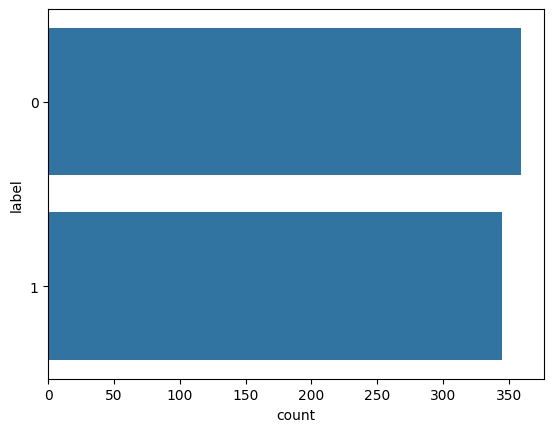

In [ ]:
# Kiểm tra cân bằng theo nhãn bệnh lý

sns.countplot(data_df['label'])
plt.show()

In [ ]:
# Tái cân bằng nhãn bệnh lý

data_df = data_df.groupby('label').sample(n=250, random_state=42)
data_df

,img,mask,label
224,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...,0
42,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...,0
572,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/MC...,0
589,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/MC...,0
56,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...,0
...,...,...,...
562,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/CH...,1
695,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/MC...,1
649,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/MC...,1
647,datasets/chest_xray/lung_segmentation/CXR_png/...,datasets/chest_xray/lung_segmentation/masks/MC...,1


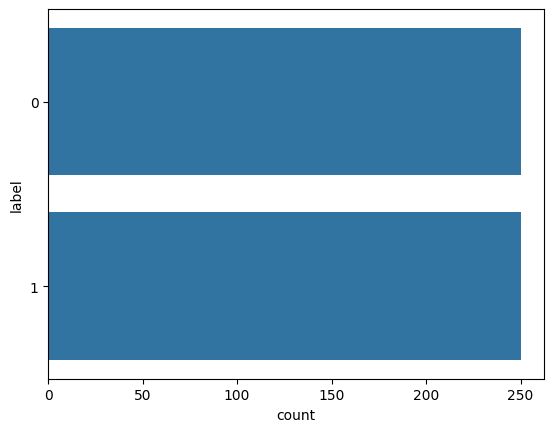

In [ ]:
# Kiểm tra lại cân bằng theo nhãn bệnh lý

sns.countplot(data_df['label'])
plt.show()

In [ ]:
# Bắt đầu nạp dữ liệu bằng tính toán song song
start_time = time()
img_mask_size = (224 ,224)

def data_parallel(data_combined):
  img_path, mask_path, label = data_combined
  label = int(label)

  img = cv.imread(img_path, 1)
  mask = cv.imread(mask_path, 0)

  img = cv.resize(img, img_mask_size)
  mask = cv.resize(mask, img_mask_size)

  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  mask = np.expand_dims(mask, axis=2)

  return img, mask, label

data_combined = data_df.values.tolist()

with Pool(cpu_count()) as pool:
  results = pool.map(data_parallel, data_combined)

images, masks, labels = zip(*results)

print(f'Append Time: {time() - start_time}')

images = np.asarray(images, dtype=np.float32)
masks = np.asarray(masks, dtype=np.float32)
labels = np.asarray(labels, dtype=np.int32)

print(images.shape, masks.shape, labels.shape)

Append Time: 312.14564418792725
(500, 224, 224, 3) (500, 224, 224, 1) (500,)


# Tiền xử lý dữ liệu

In [ ]:
# Khởi tạo nhãn cho tập dữ liệu

classes = ['normal', 'abnormal']
classes

['normal', 'abnormal']

In [ ]:
# Chuẩn hóa phạm vi dữ liệu ảnh & mask về dạng 0-1

def normalize_data(data):
  print(data.min(), data.max())
  data = data / np.max(data)
  print(data.min(), data.max())
  return data

images = normalize_data(images)
masks = normalize_data(masks)

0.0 255.0
0.0 1.0
0.0 255.0
0.0 1.0


In [ ]:
# Kiểm tra giá trị duy nhất thuộc tính label

np.unique(labels)

array([0, 1], dtype=int32)

In [ ]:
# Tách bạch từng khu vực trên mask theo ngưỡng

masks[masks < 0.5] = 0
masks[masks >= 0.5] = 1

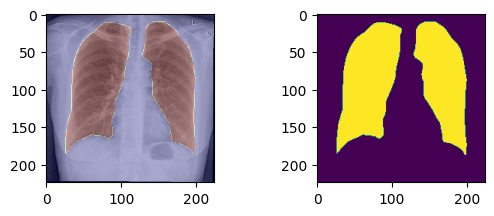

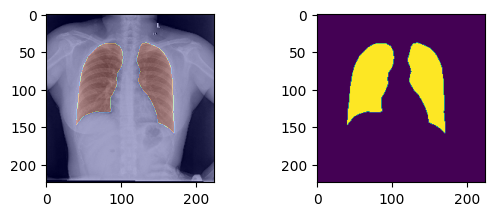

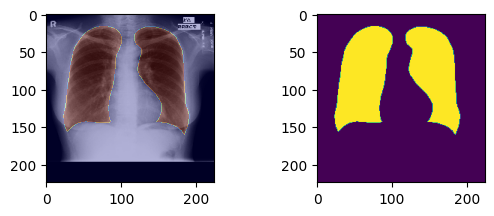

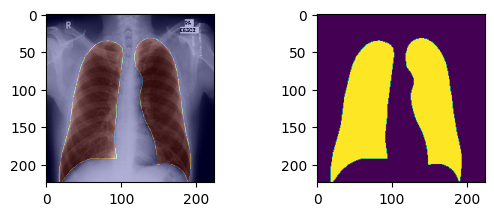

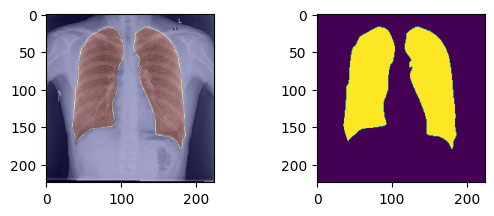

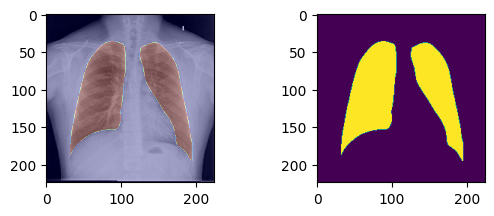

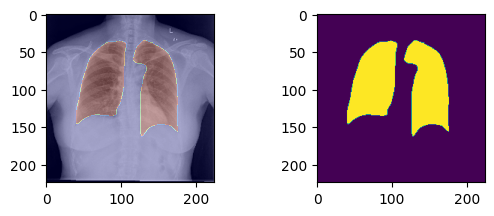

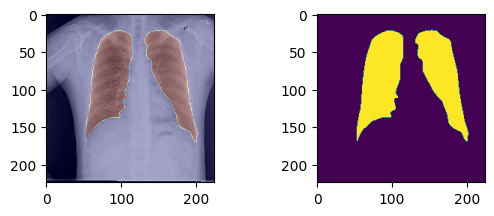

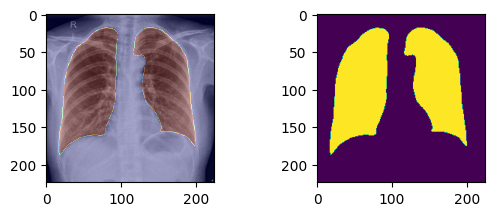

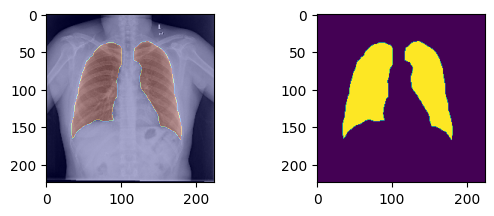

In [ ]:
# In thử mask

samples = zip(images[:10], masks[:10])

for img, mask in samples:
  plt.subplot(2, 2, 1)
  plt.imshow(img)
  plt.imshow(mask, cmap='jet', alpha=0.3)
  plt.subplot(2, 2, 2)
  plt.imshow(mask)
  plt.show()

# Xây dựng & đào tạo mô hình

In [ ]:
# Tách tập dữ liệu Train/Test
X_train, X_test, y_train_seg, y_test_seg, y_train_cls, y_test_cls = train_test_split(images, masks, labels, test_size=.20, random_state=42)

print(X_train.shape, y_train_seg.shape, y_train_cls.shape)
print(X_test.shape, y_test_seg.shape, y_test_cls.shape)

(400, 224, 224, 3) (400, 224, 224, 1) (400,)
(100, 224, 224, 3) (100, 224, 224, 1) (100,)


In [ ]:
# Lập các thang đo (metrics)

@register_keras_serializable(package='my_package', name='f1_score')
def f1_score(y_true, y_pred):
    """
    Hàm tính toán F1 Score cho phân đoạn ảnh.

    Args:
    y_true: Mảng numpy chứa nhãn thực tế.
    y_pred: Mảng numpy chứa dự đoán.

    Returns:
    f1: Giá trị F1 Score.
    """
    # Chuyển đổi tensor thành vector
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    # Tính toán TP, FP, FN
    true_positives = K.sum(y_true * y_pred)
    predicted_positives = K.sum(y_pred)
    possible_positives = K.sum(y_true)

    # Tính toán Precision và Recall
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Tính toán F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

@register_keras_serializable(package='my_package', name='iou_score')
def iou_score(y_true, y_pred):
    """
    Hàm tính toán IoU (Intersection over Union) cho phân đoạn ảnh.

    Args:
    y_true: Mảng numpy chứa nhãn thực tế.
    y_pred: Mảng numpy chứa dự đoán.

    Returns:
    iou: Giá trị IoU.
    """
    # Chuyển đổi tensor thành vector
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    # Tính toán các giá trị giao (intersection) và hợp (union)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection

    # Tính toán IoU
    iou = intersection / (union + K.epsilon())

    return iou

In [ ]:
def unet_with_classification(input_size=(224, 224, 3), seg_classes=1, cls_classes=1):
    inputs = Input(input_size)

    # Encoder (Contraction path)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder (Expansive path)
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    seg_output = Conv2D(seg_classes, (1, 1), activation='sigmoid', name="seg_output")(conv9)

    cls = GlobalAveragePooling2D()(drop5)
    cls_1 = Dense(128, activation='relu')(cls)
    cls_2 = Dense(32, activation='relu')(cls_1)
    cls_output = Dense(cls_classes, activation='sigmoid', name='cls_output')(cls_2)

    model = Model(inputs=inputs, outputs=[seg_output, cls_output])

    return model

model = unet_with_classification()

# Compile the model
model.compile(optimizer=AdamW(),
              loss={
                  'seg_output': BinaryCrossentropy(),
                  'cls_output': BinaryCrossentropy()
              },
              metrics={
                  'seg_output': [iou_score, f1_score],
                  'cls_output': ['accuracy']
              }
            )

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 28, 28, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 14, 14, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 31,167,106 (118.89 MB)

 Trainable params: 31,167,106 (118.89 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


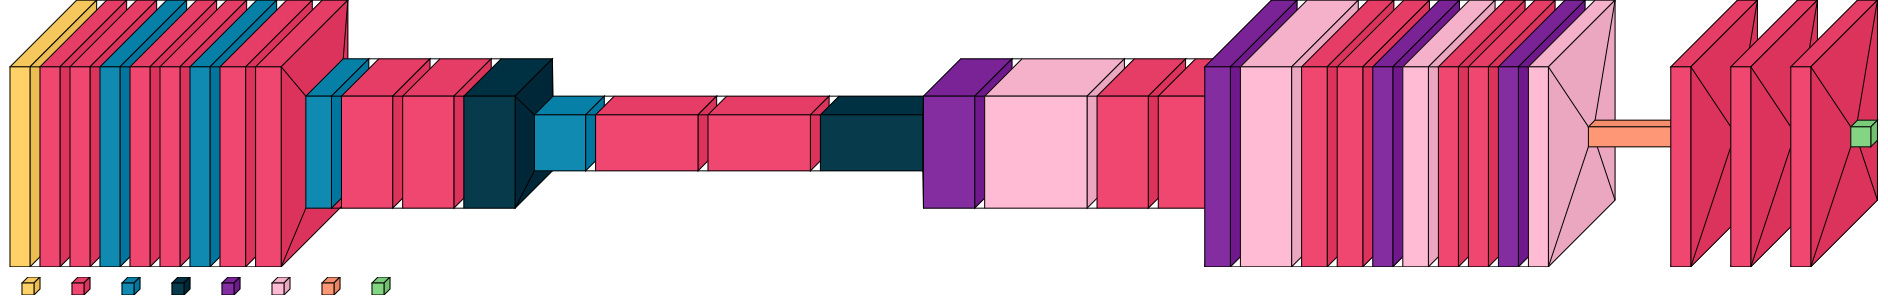

In [ ]:
# Trực quan mô hình

visualkeras.layered_view(model, legend=True, max_xy=200)

In [ ]:
# Đào tạo mô hình

model.fit(
    X_train, {'seg_output': y_train_seg, 'cls_output': y_train_cls},
    validation_data=(X_test, {'seg_output': y_test_seg, 'cls_output': y_test_cls}),
    batch_size=32,
    epochs=100,
    callbacks = [
      ModelCheckpoint(
          filepath=os.path.join(model_path, 'best_model.keras'),
          monitor='val_seg_output_f1_score',
          save_best_only=True,
          mode='max'
      ),
      TensorBoard(log_dir=log_path),
      ReduceLROnPlateau(
          monitor='val_seg_output_f1_score',
          factor=.2,
          patience=5,
          mode='max',
          min_lr=1e-4
      ),
      EarlyStopping(
          monitor='val_seg_output_f1_score',
          patience=25,
          mode='min',
          restore_best_weights=True,
          verbose=1
      )
    ]
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 227s 10s/step - cls_output_accuracy: 0.4936 - loss: 1.3884 - seg_output_f1_score: 0.2965 - seg_output_iou_score: 0.1744 - val_cls_output_accuracy: 0.4600 - val_loss: 1.2021 - val_seg_output_f1_score: 0.2986 - val_seg_output_iou_score: 0.1755 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - cls_output_accuracy: 0.5306 - loss: 1.1817 - seg_output_f1_score: 0.3128 - seg_output_iou_score: 0.1857 - val_cls_output_accuracy: 0.4600 - val_loss: 1.1498 - val_seg_output_f1_score: 0.3465 - val_seg_output_iou_score: 0.2098 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - cls_output_accuracy: 0.4980 - loss: 1.1528 - seg_output_f1_score: 0.3523 - seg_output_iou_score: 0.2146 - val_cls_output_accuracy: 0.4600 - val_loss: 1.0644 - val_seg_output_f1_score: 0.4428 - val_seg_output_iou_score: 0.2844 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - cls_output_accuracy: 0.5136 - loss: 

In [ ]:
# Lưu mô hình

model.save(os.path.join(model_path, 'final_model.keras'))

In [ ]:
# Xuất đánh giá

model.evaluate(X_test, {'seg_output': y_test_seg, 'cls_output': y_test_cls})

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - cls_output_accuracy: 0.7439 - loss: 1.5799 - seg_output_f1_score: 0.9416 - seg_output_iou_score: 0.8897


[1.5670228004455566,
 0.7400000095367432,
 0.9421342611312866,
 0.8906296491622925]

# Đánh giá mô hình

In [ ]:
# Đánh giá trên tập Test

model = load_model(os.path.join(model_path, 'best_model.keras'))
y_pred_seg, y_pred_cls = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step


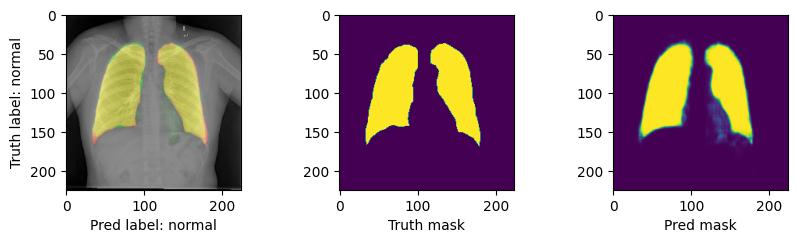

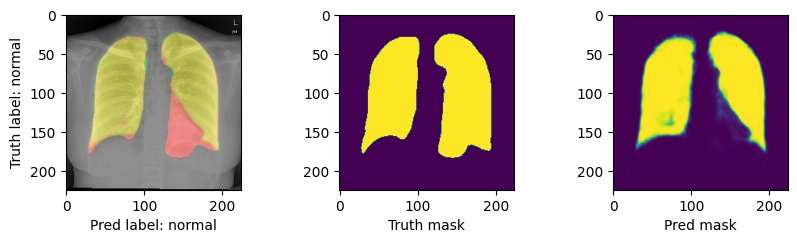

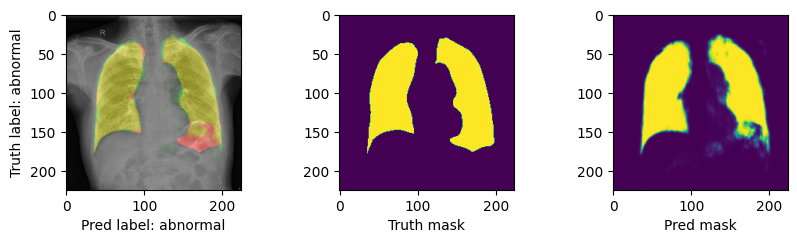

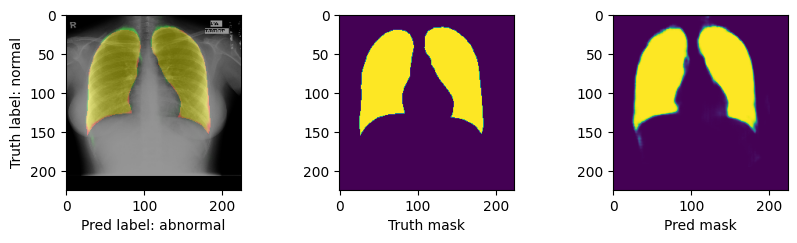

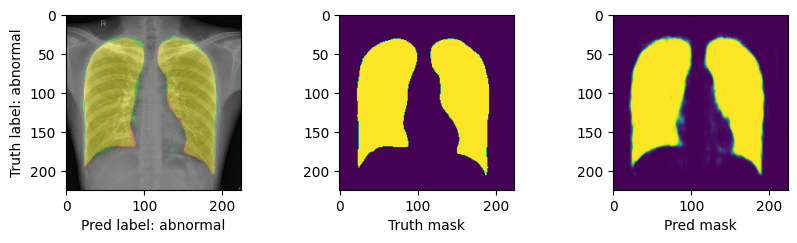

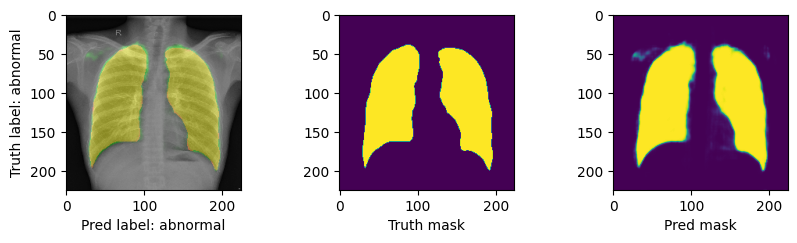

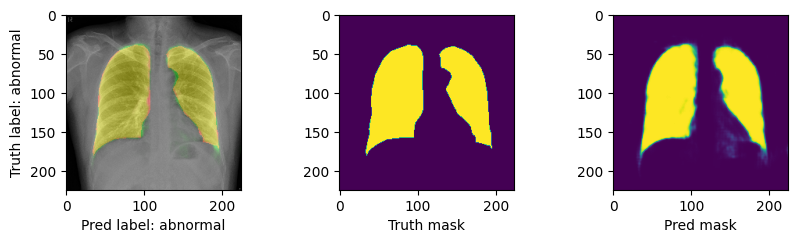

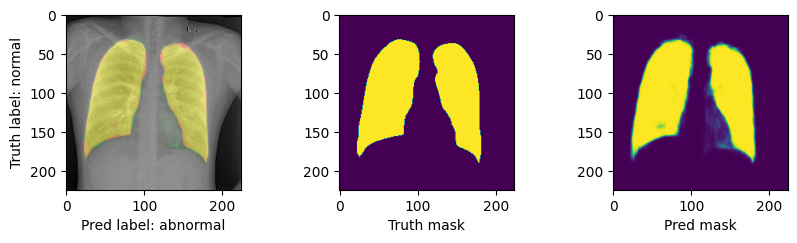

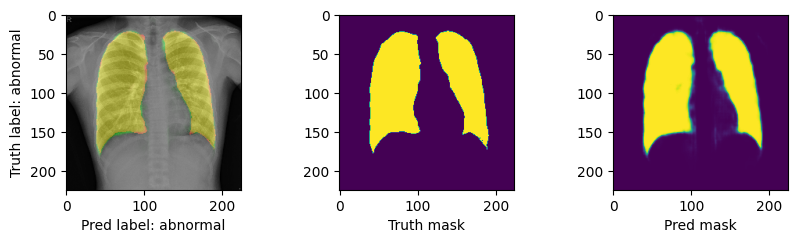

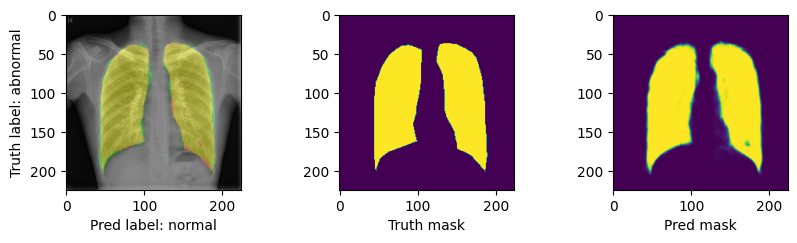

In [ ]:
# In thử vài kết quả dự đoán

samples = zip(X_test[10:20], y_test_seg[10:20], y_test_cls[10:20], y_pred_seg[10:20], y_pred_cls[10:20])

for img, truth_mask, truth_cls, pred_mask, pred_cls in samples:
  mask_to_show = np.zeros(shape=(*img.shape[:2], 3), dtype=np.uint8)
  mask_to_show[..., 0] = np.squeeze(truth_mask) * 255 # Truth mask
  mask_to_show[..., 1] = np.squeeze(pred_mask) * 255 # Pred mask
  top_cls = (pred_cls >= .5).astype(int)[0]
  pos_cls = pred_cls[0]
  neg_cls = 1 - pred_cls[0]
  plt.figure(figsize=(10, 5))
  plt.subplot(2, 3, 1)
  plt.imshow(img)
  plt.imshow(mask_to_show, alpha=.4)
  plt.xlabel(f'Pred label: {classes[top_cls]}')
  plt.ylabel(f'Truth label: {classes[truth_cls]}')
  plt.subplot(2, 3, 2)
  plt.imshow(truth_mask)
  plt.xlabel('Truth mask')
  plt.subplot(2, 3, 3)
  plt.imshow(pred_mask)
  plt.xlabel('Pred mask')
  plt.show()

# Yellow: Phần giao nhau giữa mask thực tế & dự đoán của pic đầu